# 图像分类——ResNet

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

本范例我们使用ResNet实现对小猫和小狗图片的图像分类。

In [ ]:
!pip install git+https://github.com/lyhue1991/torchkeras

In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from PIL import Image 

import torch
from torch import nn
import torchvision
from torchvision import datasets,transforms as T 

import datetime
import os
import copy
import shutil
from pathlib import Path


In [2]:
from argparse import Namespace

config = Namespace(
    img_size = 320, 
    lr = 1e-4,
    batch_size = 16,
)


## 一，准备数据

In [3]:
data_url = 'https://github.com/lyhue1991/torchkeras/releases/download/v3.7.2/cats_vs_dogs.zip'
data_file = 'cats_vs_dogs.zip'

if not os.path.exists(data_file):
    torch.hub.download_url_to_file(data_url,data_file)
    shutil.unpack_archive(data_file,'datasets')
    

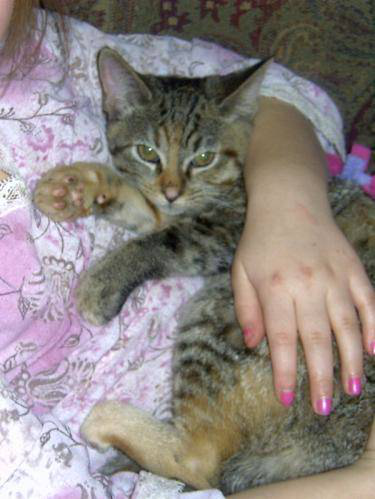

In [4]:
data_path = './datasets/cats_vs_dogs'

train_cats = os.listdir(os.path.join(data_path,"train","cats"))
img = Image.open(os.path.join(os.path.join(data_path,"train","cats",train_cats[0])))
img 


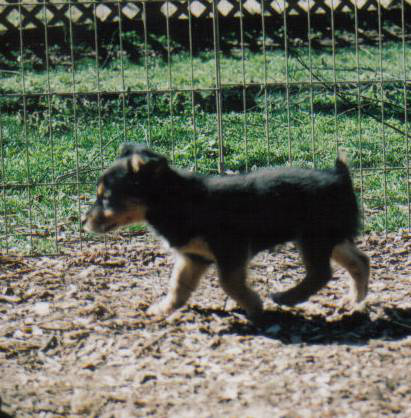

In [5]:
train_dogs = os.listdir(os.path.join(data_path,"train","dogs"))
img = Image.open(os.path.join(os.path.join(data_path,"train","dogs",train_dogs[0])))
img 


In [7]:
mean = (0.0, 0.0, 0.0)
std = (1.0, 1.0, 1.0)
transforms_train = T.Compose([
        T.Resize((config.img_size,config.img_size)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=mean,std=std)
    ])
transforms_val = T.Compose([
        T.Resize((config.img_size,config.img_size)),
        T.ToTensor(),
        T.Normalize(mean=mean,std=std)
    ])

def transform_label(x):
    return  torch.tensor([x],dtype = torch.float)
    
    
ds_train = datasets.ImageFolder(os.path.join(data_path,"train"),transforms_train,
            target_transform = transform_label)
ds_val = datasets.ImageFolder(os.path.join(data_path,"val"),transforms_val,
          target_transform = transform_label)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=config.batch_size,
                                             shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=config.batch_size,
                                             shuffle=False)

class_names = ds_train.classes

print(len(ds_train))
print(len(ds_val))


2000
995


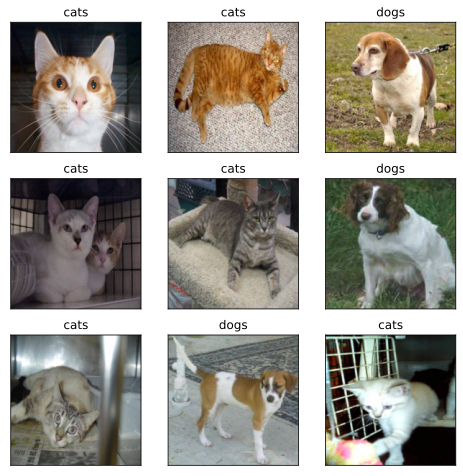

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(8,8)) 
idxes = np.random.choice(range(len(ds_train)),9)

for i in range(9):
    idx = idxes[i]
    img,label = ds_train[idx]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title(f"{class_names[label.int().item()]}")
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()



## 二，构建模型

In [9]:
for features,labels in dl_train:
    break 

In [10]:
from importlib import reload 
import torchkeras 

<module 'torchkeras.fastprogress' from '/opt/conda/lib/python3.7/site-packages/torchkeras/fastprogress.py'>

In [11]:
from torchkeras.models import ResNet50 
from torchkeras import summary 

net = ResNet50(num_classes=1).cuda()

summary(net,input_data=features.cuda());


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                          [-1, 64, 160, 160]                9,408
BatchNorm2d-2                     [-1, 64, 160, 160]                  128
ReLU-3                            [-1, 64, 160, 160]                    0
MaxPool2d-4                         [-1, 64, 80, 80]                    0
Conv2d-5                           [-1, 256, 80, 80]               16,384
BatchNorm2d-6                      [-1, 256, 80, 80]                  512
Conv2d-7                            [-1, 64, 80, 80]                4,096
BatchNorm2d-8                       [-1, 64, 80, 80]                  128
ReLU-9                              [-1, 64, 80, 80]                    0
Conv2d-10                           [-1, 64, 80, 80]               36,864
BatchNorm2d-11                      [-1, 64, 80, 80]                  128
ReLU-12                             [

In [ ]:
!nvidia-smi 

## 三，训练模型

In [12]:
from torchkeras import KerasModel 
from torchmetrics import Accuracy


loss_fn = nn.BCEWithLogitsLoss()
metrics_dict = {"acc":Accuracy(task='binary')}

optimizer = torch.optim.Adam(net.parameters(),
                            lr=config.lr)

model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer
                  )     



<<<<<< ⚡️ cuda is used >>>>>>


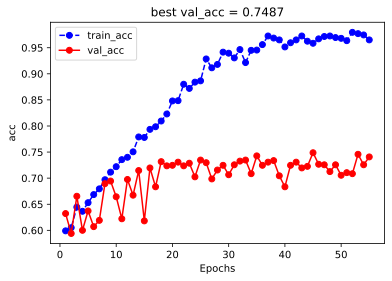

epoch,train_loss,train_acc,lr,val_loss,val_acc
1.0,0.6796388063430786,0.5989999771118164,0.0001,0.673592198935766,0.6321607828140259
2.0,0.664274023771286,0.6050000190734863,0.0001,0.7222051109586444,0.5939698219299316
3.0,0.6427086753845215,0.6445000171661377,0.0001,0.6101197023240347,0.6653266549110413
4.0,0.6457438304424286,0.6365000009536743,0.0001,0.6634068427577852,0.6000000238418579
5.0,0.620329873085022,0.652999997138977,0.0001,0.6359799650926439,0.6371859312057495
6.0,0.6105752568244934,0.6685000061988831,0.0001,0.6508720053566827,0.6070351600646973
7.0,0.5878100774288177,0.6794999837875366,0.0001,0.6697586798478686,0.619095504283905
8.0,0.5836356275081634,0.6970000267028809,0.0001,0.5974742628279186,0.6894472241401672
9.0,0.5633330764770508,0.7114999890327454,0.0001,0.6008948641163963,0.6944723725318909
10.0,0.5453073978424072,0.722000002861023,0.0001,0.6588436317822289,0.6643216013908386



================================================================================2023-03-10 10:20:00
Epoch 1 / 100

100%|████████████████████████████████| 63/63 [00:09<00:00,  6.88it/s, val_acc=0.632, val_loss=0.674]
<<<<<< reach best val_acc : 0.6321607828140259 >>>>>>

================================================================================2023-03-10 10:20:47
Epoch 2 / 100

100%|████████████████████████████████| 63/63 [00:09<00:00,  6.85it/s, val_acc=0.594, val_loss=0.722]

================================================================================2023-03-10 10:21:34
Epoch 3 / 100

100%|█████████████████████████████████| 63/63 [00:09<00:00,  6.67it/s, val_acc=0.665, val_loss=0.61]
<<<<<< reach best val_acc : 0.6653266549110413 >>>>>>

================================================================================2023-03-10 10:22:20
Epoch 4 / 100

100%|██████████████████████████████████| 63/63 [00:09<00:00,  6.70it/s, val_acc=0.6, val_loss=0.663]

=======================

In [13]:
dfhistory=model.fit(train_data=dl_train, 
                    val_data=dl_val, 
                    epochs=100, 
                    ckpt_path='checkpoint.pt',
                    patience=10, 
                    monitor="val_acc",
                    mode="max",
                    mixed_precision='no',
                    plot = True
                   )

## 四，评估模型

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    

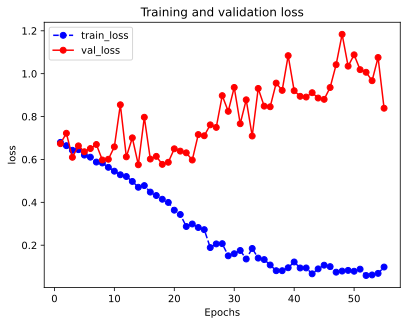

In [15]:
plot_metric(dfhistory,"loss")

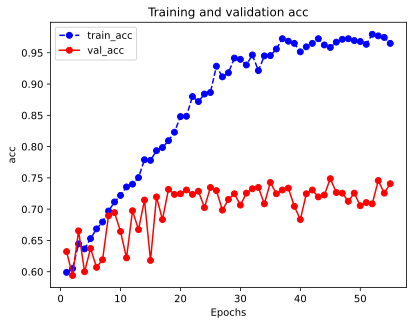

In [16]:
plot_metric(dfhistory,"acc")

In [17]:
model.evaluate(dl_val)

100%|█████████████████████████████████| 63/63 [00:09<00:00,  6.83it/s, val_acc=0.749, val_loss=0.88]


{'val_loss': 0.8803266868704841, 'val_acc': 0.7487437129020691}

## 五，使用模型

In [43]:
net.eval();

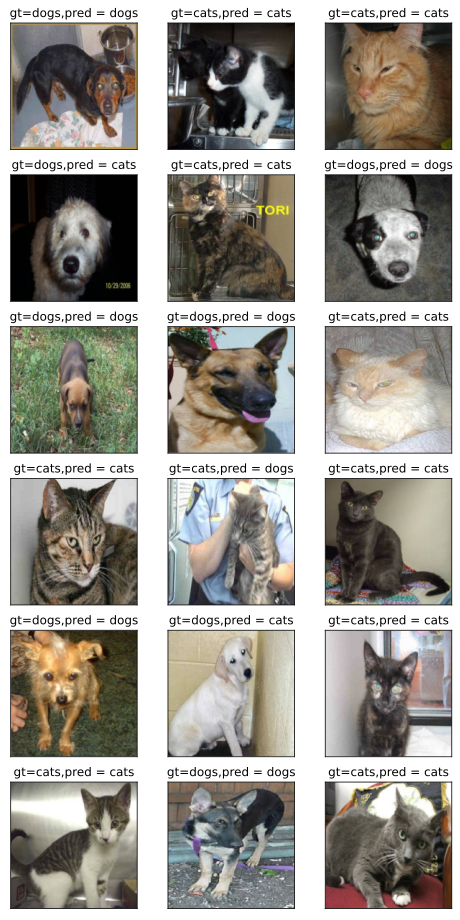

In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(8,16)) 
idxes = np.random.choice(range(len(ds_val)),18)

for i in range(18):
    idx = idxes[i]
    img,label = ds_val[idx]
    tensor = img.unsqueeze(dim=0).cuda() 
    score = net(tensor).sigmoid().item()
    pred = class_names[0] if score<0.5 else class_names[1]
    img = img.permute(1,2,0)
    ax=plt.subplot(6,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title(f"gt={class_names[label.int().item()]},pred = {pred}")
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

## 六，保存模型




In [45]:
torch.save(net.state_dict(), 'resnet_dogcat.pt')

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)